<a href="https://colab.research.google.com/github/CYBERCONQUEROR/AGENT/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# Download once
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load dataset
df = pd.read_csv("/content/Combined_Data.csv")

# Drop unwanted column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Initialize tools
stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()                               # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)              # Remove punctuation & numbers
    tokens = text.split()                             # Tokenization
    tokens = [word for word in tokens if word not in stop_words]
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Handle missing values in 'statement' column by filling with empty strings
df['statement'] = df['statement'].fillna('')

# Apply preprocessing
df['clean_text'] = df['statement'].apply(preprocess_text)


# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])

print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                           statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                          clean_text  label  
0                                            oh gosh      0  
1  trouble sleeping confused mind restless heart ...      0  
2  wrong back dear forward doubt stay restless re...      0  
3  ive shifted focus something else im still worried      0  
4                im restless restless month boy mean      0  


In [ ]:
df['clean_text']

,clean_text
0,oh gosh
1,trouble sleeping confused mind restless heart ...
2,wrong back dear forward doubt stay restless re...
3,ive shifted focus something else im still worried
4,im restless restless month boy mean
...,...
53038,nobody takes seriously ive dealt depressionanx...
53039,selfishness dont feel good like dont belong wo...
53040,way sleep better cant sleep nights meds didnt ...
53041,public speaking tips hi give presentation work...


In [ ]:
df.to_csv("preprocessed_dataset.csv", index=False)


In [ ]:
# ==============================
# 1️⃣ IMPORTS
# ==============================
import time
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ==============================
# 2️⃣ LOAD DATASET
# ==============================
df = pd.read_csv("/content/preprocessed_dataset.csv")
# Ensure clean_text column is all strings
df['clean_text'] = df['clean_text'].astype(str)


# ==============================
# 3️⃣ TOKENIZATION
# ==============================
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

encodings = tokenize_data(df['clean_text'])
labels = torch.tensor(df['label'].values)

# ==============================
# 4️⃣ TRAIN–VALIDATION SPLIT
# ==============================
train_idx, val_idx = train_test_split(
    range(len(labels)), test_size=0.2, random_state=42
)

train_encodings = {k: v[train_idx] for k, v in encodings.items()}
val_encodings   = {k: v[val_idx] for k, v in encodings.items()}

train_labels = labels[train_idx]
val_labels   = labels[val_idx]

# ==============================
# 5️⃣ DATASET CLASS
# ==============================
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset   = TextDataset(val_encodings, val_labels)


# ==============================
# 6️⃣ MODEL: BERT + BiLSTM
# ==============================
# class BertBiLSTM(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()

#         self.bert = BertModel.from_pretrained("bert-base-uncased")
#         self.lstm = nn.LSTM(
#             input_size=768,
#             hidden_size=128,
#             num_layers=1,
#             bidirectional=True,
#             batch_first=True
#         )
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(256, num_classes)

#     def forward(self, input_ids, attention_mask):
#         bert_output = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )

#         sequence_output = bert_output.last_hidden_state
#         lstm_out, _ = self.lstm(sequence_output)

#         pooled_output = torch.mean(lstm_out, dim=1)
#         pooled_output = self.dropout(pooled_output)

#         return self.fc(pooled_output)

# ==============================
# 6️⃣ MODEL: BERT ONLY
# ==============================


class BertOnly(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.pooler_output
        return self.fc(self.dropout(pooled))


# ==============================
# 7️⃣ DEVICE & GPU INFO
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n🔍 Device Information")
print(f"🖥️ Device in use: {device}")

if device.type == "cuda":
    print(f"🚀 GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"🔥 CUDA Version: {torch.version.cuda}")
    print(f"💾 Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ GPU not detected, using CPU")

print("\n🔤 Tokenization Details")
print(f"📌 Tokenizer: {MODEL_NAME}")
print(f"📏 Max Length: {MAX_LEN}")
print(f"🧠 Training samples: {len(train_labels)}")
print(f"🧠 Validation samples: {len(val_labels)}")

# ==============================
# 8️⃣ TRAINING SETUP
# ==============================
model = BertBiLSTM(num_classes=len(df['label'].unique()))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5) #lr=1e-5
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # batch_size=8
val_loader   = DataLoader(val_dataset, batch_size=16)

# ==============================
# 9️⃣ TRAINING LOOP (TIME + EMOJIS)
# ==============================
EPOCHS = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

training_start_time = time.time()
print("\n🚀 Training started...\n")

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    model.train()
    total_loss, preds, true = 0, [], []

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        true.extend(labels_batch.cpu().numpy())

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(accuracy_score(true, preds))

    # ===== VALIDATION =====
    model.eval()
    total_loss, preds, true = 0, [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_batch = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels_batch)

            total_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true.extend(labels_batch.cpu().numpy())

    val_losses.append(total_loss / len(val_loader))
    val_accs.append(accuracy_score(true, preds))

    epoch_time = time.time() - epoch_start_time

    print(
        f"📘 Epoch {epoch+1}/{EPOCHS} | "
        f"⏱️ {epoch_time:.2f}s | "
        f"📉 Train Loss: {train_losses[-1]:.4f} | "
        f"📈 Train Acc: {train_accs[-1]:.4f} | "
        f"✅ Val Acc: {val_accs[-1]:.4f}"
    )

    if device.type == "cuda":
        print(f"💾 GPU Memory Used: {torch.cuda.memory_allocated() / 1e9:.2f} GB\n")

# ==============================
# 🔟 TOTAL TRAINING TIME
# ==============================
total_training_time = time.time() - training_start_time

print("\n🎉 Training completed!")
print(f"⏳ Total training time: {total_training_time/60:.2f} minutes")


🔍 Device Information
🖥️ Device in use: cuda
🚀 GPU Name: Tesla T4
🔥 CUDA Version: 12.6
💾 Total GPU Memory: 15.83 GB

🔤 Tokenization Details
📌 Tokenizer: bert-base-uncased
📏 Max Length: 128
🧠 Training samples: 42434
🧠 Validation samples: 10609

🚀 Training started...

📘 Epoch 1/5 | ⏱️ 1015.92s | 📉 Train Loss: 0.6941 | 📈 Train Acc: 0.7359 | ✅ Val Acc: 0.7962
💾 GPU Memory Used: 3.56 GB

📘 Epoch 2/5 | ⏱️ 1013.48s | 📉 Train Loss: 0.4785 | 📈 Train Acc: 0.8127 | ✅ Val Acc: 0.8028
💾 GPU Memory Used: 3.56 GB

📘 Epoch 3/5 | ⏱️ 1013.52s | 📉 Train Loss: 0.3721 | 📈 Train Acc: 0.8544 | ✅ Val Acc: 0.8087
💾 GPU Memory Used: 3.56 GB

📘 Epoch 4/5 | ⏱️ 1013.04s | 📉 Train Loss: 0.2771 | 📈 Train Acc: 0.8958 | ✅ Val Acc: 0.7962
💾 GPU Memory Used: 3.56 GB

📘 Epoch 5/5 | ⏱️ 1013.23s | 📉 Train Loss: 0.2015 | 📈 Train Acc: 0.9280 | ✅ Val Acc: 0.8025
💾 GPU Memory Used: 3.56 GB


🎉 Training completed!
⏳ Total training time: 84.49 minutes


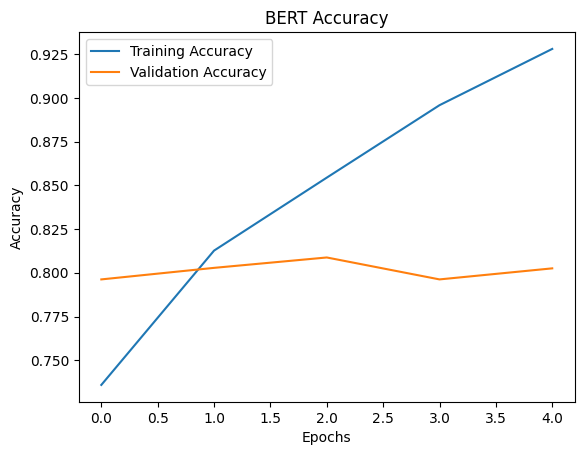

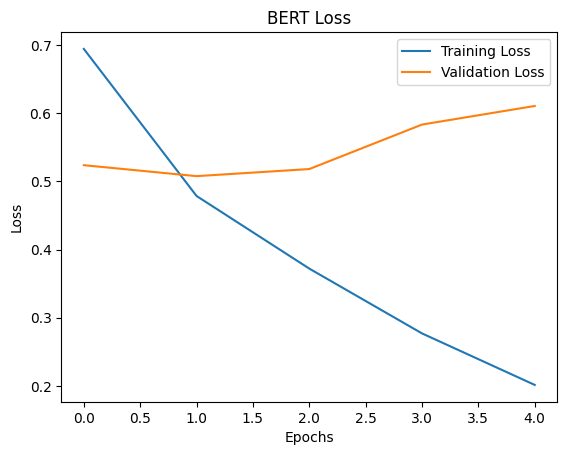

In [ ]:
import matplotlib.pyplot as plt

# ---- Accuracy Plot ----
plt.figure()
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("BERT Accuracy")
plt.legend()

plt.savefig("bert_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()


# ---- Loss Plot ----
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("BERT Loss")
plt.legend()

plt.savefig("bert_loss.png", dpi=300, bbox_inches="tight")
plt.show()


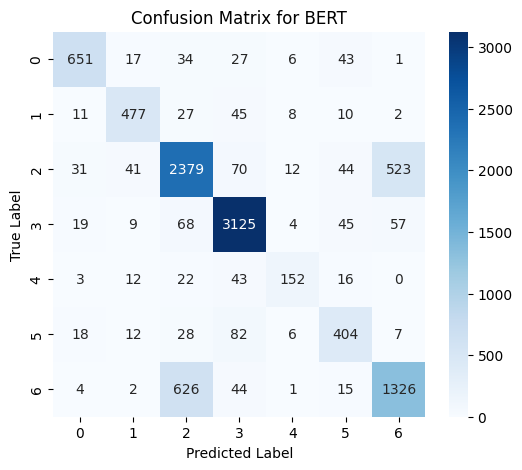

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for BERT")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])

# Save class names in correct order
class_names = le.classes_.tolist()
class_names

['Anxiety',
 'Bipolar',
 'Depression',
 'Normal',
 'Personality disorder',
 'Stress',
 'Suicidal']

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    all_true,
    all_preds,
    target_names=class_names,
    digits=4,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()


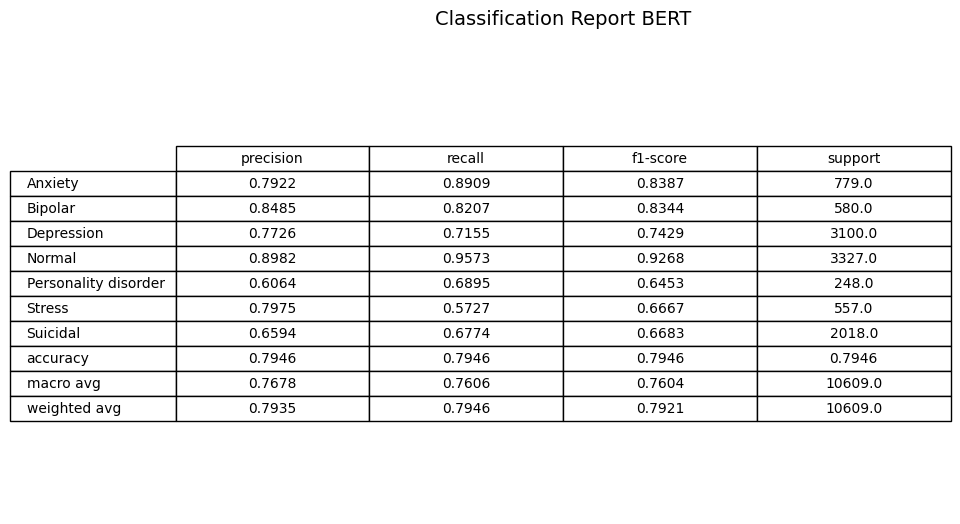

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.axis('off')

table = plt.table(
    cellText=report_df.round(4).values,
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    loc='center',
    cellLoc='center'
)

table.scale(1, 1.5)

plt.title("Classification Report BERT", fontsize=14, pad=20)

plt.savefig("classification_report.png", dpi=300, bbox_inches='tight')
plt.show()
